# Libraries and Functions

In [ ]:
#!pip install ppscore
#!pip install meteostat
#!pip install shap
#!pip install fancyimpute

  Preparing metadata (setup.py) ... done
  Created wheel for ppscore: filename=ppscore-1.3.0-py2.py3-none-any.whl size=13164 sha256=8f06e76b1340277039695fdd283430b8dac55b2728d79f1da7ed6c430cdc9126
  Stored in directory: /root/.cache/pip/wheels/42/87/10/00056aa2d2624f1b9374db6a0d5245da9a3d87bdc9247c1a56
Successfully built ppscore
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 2.2 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29880 sha256=c34f9d2510fc32741968cb4ae5c2c986f3e752aa701f21265ec72a5addf6db49
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11329 sha256=2791f06976a4b9281a1da603920926a1052eae8cb71847818f5e618c130be1bc


In [3]:
#Setting environment variables.
import os

full_path = os.getenv("OPERATING_SYSTEM_PATH")
     
if full_path is None: 
   #Element doesn't exist.
   os.environ["OPERATING_SYSTEM_PATH"] = "/home/cdsw/"

In [6]:
#Loading Libraries
import warnings
import scipy.stats as stats
import ppscore as pps
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from  sklearn.decomposition import  PCA
from sklearn import preprocessing
from sklearn import tree
from sklearn.manifold import TSNE
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
%matplotlib inline
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from tqdm import tqdm_notebook
import matplotlib.gridspec as gridspec
import gc
from sklearn.feature_selection import f_regression,mutual_info_regression,SelectKBest
from sklearn.metrics import mean_squared_error,r2_score,roc_auc_score, mean_absolute_error
from datetime import datetime
from meteostat import Point, Daily,Hourly
import meteostat as me
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
import lightgbm as lgb
import xgboost as xgb
import shap
import pickle
from sklearn.impute import KNNImputer
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingRegressor

from fancyimpute import KNN
#Better output format
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def describe_plus(df):
    return pd.concat([df.describe().T,
                      df.mad().rename('mad'),
                      df.skew().rename('skew'),
                      df.kurt().rename('kurt')], axis=1).T
## ppscore matrix
def heatmap(df):
    df = df[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
    plt.figure(figsize=(10,10))
    ax = sns.heatmap(df, vmin=0, vmax=1, cmap="Reds", linewidths=0.5, annot=True)
    ax.set_title("PPS matrix")
    ax.set_xlabel("feature")
    ax.set_ylabel("target")
    return ax

def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in.
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings

            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)

            # Make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()

            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all():
                NAlist.append(col)
                props[col].fillna(0,inplace=True)

            # Test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True


            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)

            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)

            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")

    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [ ]:
df_0=pd.read_csv(os.getenv("OPERATING_SYSTEM_PATH") + "src/data/semi_raw_meteorological_dataset.csv")

In [ ]:
# Useful function to reduce data usage
df, NAlist = reduce_mem_usage(df_0)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min()': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 2.5067138671875  MB
******************************
Column:  sequential_id
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  latitude
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  longitude
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  pressure
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  wind_speed
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  air_temperature
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  dew_point
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  relative_humidity

# **Exploratory Data Analysis (EDA)**

## Data Overview

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20534 entries, 0 to 20533
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sequential_id      20534 non-null  uint16 
 1   name               20534 non-null  object 
 2   timestamp_utc      20534 non-null  object 
 3   latitude           20534 non-null  float32
 4   longitude          20534 non-null  float32
 5   pressure           20534 non-null  uint16 
 6   wind_speed         20534 non-null  uint8  
 7   closest_stations   20534 non-null  object 
 8   air_temperature    20534 non-null  float32
 9   dew_point          20534 non-null  float32
 10  relative_humidity  20534 non-null  uint8  
 11  precipitation      20534 non-null  float32
 12  condition_code     20534 non-null  uint8  
 13  wind_direction     20534 non-null  uint16 
 14  final_press        20534 non-null  float32
 15  final_wspd         20534 non-null  float32
dtypes: float32(7), object(

In [ ]:
# Change final_press to avg_press and final_wspd to avg_wspd
df.rename(columns={"final_press": "avg_press", "final_wspd": "avg_wspd"}, inplace=True)

In [ ]:
# Convert kt to km/h. Multiply wind_speed by 1.852
df['avg_wspd'] = df['avg_wspd'] / 1.852

In [ ]:
# Create a column in df that calculates the rate of change of the wind_speed variable of each sequential_id
df['rate_of_change_wind_speed'] = (df.groupby('sequential_id')['wind_speed'].shift(-1) - df['wind_speed']) / df['wind_speed']

In [ ]:
df.head()

,sequential_id,name,timestamp_utc,latitude,longitude,pressure,wind_speed,closest_stations,air_temperature,dew_point,relative_humidity,precipitation,condition_code,wind_direction,avg_press,avg_wspd,rate_of_change_wind_speed
0,1,Hurricane Kilo,2015-08-20 00:00:00,10.000,145.300,1008,20,[],0.000,0.000,0,0.000,0,0,0.000,0.000,0.250
1,1,Hurricane Kilo,2015-08-20 12:00:00,10.600,148.000,1007,25,[],0.000,0.000,0,0.000,0,0,0.000,0.000,0.000
2,1,Hurricane Kilo,2015-08-20 18:00:00,11.000,149.100,1007,25,[],0.000,0.000,0,0.000,0,0,0.000,0.000,0.000
3,1,Hurricane Kilo,2015-08-21 00:00:00,11.600,150.000,1007,25,[],0.000,0.000,0,0.000,0,0,0.000,0.000,0.000
4,1,Hurricane Kilo,2015-08-21 06:00:00,12.200,150.900,1007,25,[],0.000,0.000,0,0.000,0,0,0.000,0.000,0.000


In [ ]:
df.tail()

,sequential_id,name,timestamp_utc,latitude,longitude,pressure,wind_speed,closest_stations,air_temperature,dew_point,relative_humidity,precipitation,condition_code,wind_direction,avg_press,avg_wspd,rate_of_change_wind_speed
20529,676,Hurricane Jimena,2015-09-08 18:00:00,26.200,152.800,995,50,[],0.000,0.000,0,0.000,0,0,0.000,0.000,-0.100
20530,676,Hurricane Jimena,2015-09-09 00:00:00,26.000,153.600,998,45,[],0.000,0.000,0,0.000,0,0,0.000,0.000,-0.111
20531,676,Hurricane Jimena,2015-09-09 06:00:00,25.800,154.500,1000,40,[],0.000,0.000,0,0.000,0,0,0.000,0.000,-0.250
20532,676,Hurricane Jimena,2015-09-09 12:00:00,25.500,155.200,1004,30,[],0.000,0.000,0,0.000,0,0,0.000,0.000,0.000
20533,676,Hurricane Jimena,2015-09-09 18:00:00,25.000,156.000,1005,30,[],0.000,0.000,0,0.000,0,0,0.000,0.000,NaN


In [ ]:
df.describe()

,sequential_id,latitude,longitude,pressure,wind_speed,air_temperature,dew_point,relative_humidity,precipitation,condition_code,wind_direction,avg_press,avg_wspd,rate_of_change_wind_speed
count,20534.000,20534.000,20534.000,20534.000,20534.000,20534.000,20534.000,20534.000,20534.000,20534.000,20534.000,20534.000,20534.000,19807.000
mean,377.366,22.375,89.610,995.362,47.231,13.593,9.119,34.279,0.015,0.361,76.426,458.688,2.307,0.008
std,217.616,9.484,36.065,17.640,25.103,13.994,11.047,38.003,0.207,1.827,113.753,502.134,3.992,0.137
min,1.000,1.900,0.000,872.000,10.000,-22.800,-29.400,0.000,0.000,0.000,0.000,0.000,0.000,-0.700
25%,186.000,15.500,59.400,990.000,30.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,376.000,19.500,93.900,1002.000,40.000,10.700,0.000,12.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,568.000,27.900,117.100,1007.000,55.000,27.100,22.400,75.000,0.000,0.000,150.000,1007.300,3.888,0.045
max,747.000,118.900,179.900,1024.000,185.000,49.100,36.200,101.000,12.200,27.000,360.000,1077.000,95.842,6.500


## Missing Values

In [ ]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)*100
data_null = pd.concat([total, percent], axis=1, keys=['Total', 'Percentage'])
data_null.head(50)

,Total,Percentage
rate_of_change_wind_speed,727,3.540
dew_point,0,0.000
avg_wspd,0,0.000
avg_press,0,0.000
wind_direction,0,0.000
condition_code,0,0.000
precipitation,0,0.000
relative_humidity,0,0.000
sequential_id,0,0.000
name,0,0.000


## Categorical Data

In [ ]:
df.select_dtypes(include='object')

,name,timestamp_utc,closest_stations
0,Hurricane Kilo,2015-08-20 00:00:00,[]
1,Hurricane Kilo,2015-08-20 12:00:00,[]
2,Hurricane Kilo,2015-08-20 18:00:00,[]
3,Hurricane Kilo,2015-08-21 00:00:00,[]
4,Hurricane Kilo,2015-08-21 06:00:00,[]
...,...,...,...
20529,Hurricane Jimena,2015-09-08 18:00:00,[]
20530,Hurricane Jimena,2015-09-09 00:00:00,[]
20531,Hurricane Jimena,2015-09-09 06:00:00,[]
20532,Hurricane Jimena,2015-09-09 12:00:00,[]


In [ ]:
df['name'].value_counts()

Hurricane Jimena             192
Hurricane Linda              180
Hurricane Marie              171
Hurricane Maria              159
Hurricane Darby              153
                            ... 
Tropical Storm Dora            5
Tropical Storm Amanda          5
Tropical Depression Three      5
Tropical Storm Iune            4
Tropical Depression Two-E      3
Name: name, Length: 478, dtype: int64

In [ ]:
df.groupby(['name']).max().sort_values(by='wind_speed',ascending=False)

,sequential_id,timestamp_utc,latitude,longitude,pressure,wind_speed,closest_stations,air_temperature,dew_point,relative_humidity,precipitation,condition_code,wind_direction,avg_press,avg_wspd,rate_of_change_wind_speed
name,,,,,,,,,,,,,,,,
Hurricane Patricia,574,2015-10-24 00:00:00,19.600,115.500,1009,185,[],34.700,26.800,97,3.000,0,360,1014.300,9.719,0.304
Hurricane Dorian,547,2019-09-09 00:00:00,51.600,79.700,1011,160,[],33.500,28.200,100,0.000,8,360,1025.400,22.030,0.200
Hurricane Wilma,89,2005-10-26 18:00:00,45.500,87.100,1004,160,"['43221', '43220', '43243', '43177', '43180', ...",29.200,25.400,100,0.000,0,360,1024.400,17.495,0.733
Hurricane Irma,188,2017-09-13 12:00:00,36.800,90.100,1008,155,[],40.400,27.600,95,0.000,5,360,1019.000,11.069,0.286
Hurricane Rita,510,2005-09-26 00:00:00,37.000,94.100,1009,155,[],31.000,26.600,97,0.000,0,340,1009.100,16.901,0.286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tropical Depression Five,59,2010-08-18 00:00:00,33.000,91.000,1013,30,[],35.400,26.700,88,0.000,0,270,1003.300,5.076,0.333
Tropical Depression Three,406,2019-07-23 12:00:00,28.600,80.000,1014,30,"['42559', '42459', '42557', '42669', '42555', ...",36.200,28.700,77,0.000,5,270,1000.600,7.019,0.200
Tropical Depression Seven,577,2003-07-27 00:00:00,33.000,83.000,1022,30,[],43.000,24.100,50,0.000,0,330,1005.100,7.019,0.200


## Numerical Data

In [ ]:
#df with numerical columns
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].astype('float64')

dfaux=df[num_cols]
features=dfaux.columns

In [ ]:
describe_plus(dfaux)

,sequential_id,latitude,longitude,pressure,wind_speed,air_temperature,dew_point,relative_humidity,precipitation,condition_code,wind_direction,avg_press,avg_wspd,rate_of_change_wind_speed
count,20534.000,20534.000,20534.000,20534.000,20534.000,20534.000,20534.000,20534.000,20534.000,20534.000,20534.000,20534.000,20534.000,19807.000
mean,377.366,22.375,89.610,995.362,47.231,13.593,9.119,34.279,0.015,0.361,76.426,458.688,2.307,0.008
std,217.616,9.484,36.065,17.640,25.103,13.994,11.047,38.003,0.207,1.827,113.753,502.134,3.992,0.137
min,1.000,1.900,0.000,872.000,10.000,-22.800,-29.400,0.000,0.000,0.000,0.000,0.000,0.000,-0.700
25%,186.000,15.500,59.400,990.000,30.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,376.000,19.500,93.900,1002.000,40.000,10.700,0.000,12.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,568.000,27.900,117.100,1007.000,55.000,27.100,22.400,75.000,0.000,0.000,150.000,1007.300,3.888,0.045
max,747.000,118.900,179.900,1024.000,185.000,49.100,36.200,101.000,12.200,27.000,360.000,1077.000,95.842,6.500
mad,188.073,7.492,31.006,13.133,19.268,13.410,10.290,35.508,0.030,0.659,96.224,500.058,2.861,0.077
skew,-0.032,1.274,-0.097,-1.807,1.419,0.208,0.462,0.438,26.749,8.196,1.204,0.181,3.263,9.943


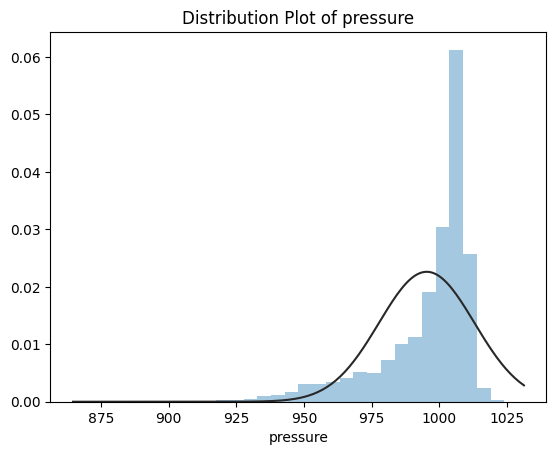

In [ ]:
# Create distribution plot
sns.distplot(dfaux['pressure'], kde=False, fit=stats.norm, bins=30)
plt.title('Distribution Plot of pressure')

# Show the plot
plt.show()

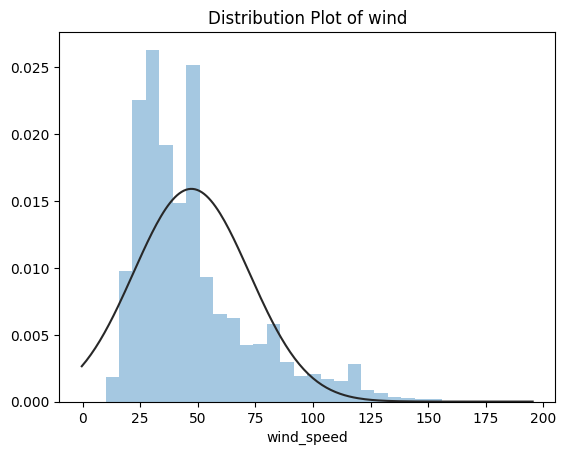

In [ ]:
# Create distribution plot
sns.distplot(dfaux['wind_speed'], kde=False, fit=stats.norm, bins=30)
plt.title('Distribution Plot of wind')

# Show the plot
plt.show()

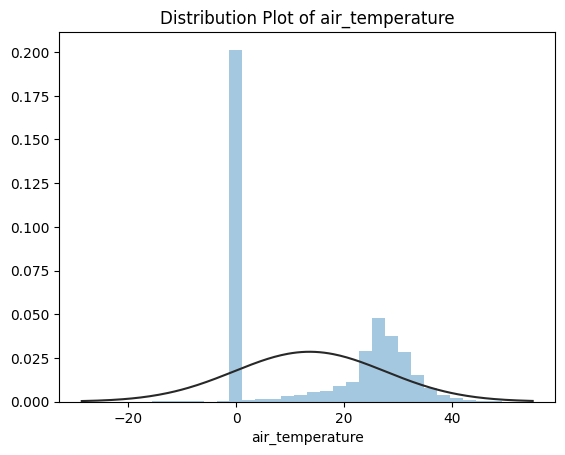

In [ ]:
# Create distribution plot
sns.distplot(dfaux['air_temperature'], kde=False, fit=stats.norm, bins=30)
plt.title('Distribution Plot of air_temperature')

# Show the plot
plt.show()

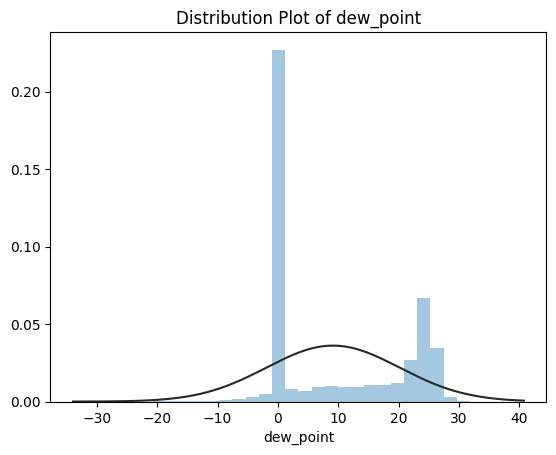

In [ ]:
# Create distribution plot
sns.distplot(dfaux['dew_point'], kde=False, fit=stats.norm, bins=30)
plt.title('Distribution Plot of dew_point')

# Show the plot
plt.show()

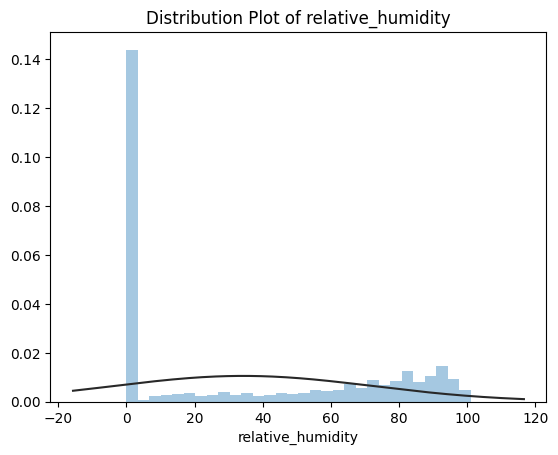

In [ ]:
# Create distribution plot
sns.distplot(dfaux['relative_humidity'], kde=False, fit=stats.norm, bins=30)
plt.title('Distribution Plot of relative_humidity')

# Show the plot
plt.show()

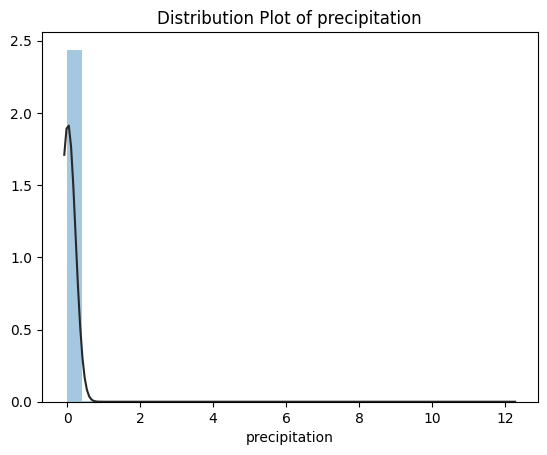

In [ ]:
# Create distribution plot
sns.distplot(dfaux['precipitation'], kde=False, fit=stats.norm, bins=30)
plt.title('Distribution Plot of precipitation')

# Show the plot
plt.show()

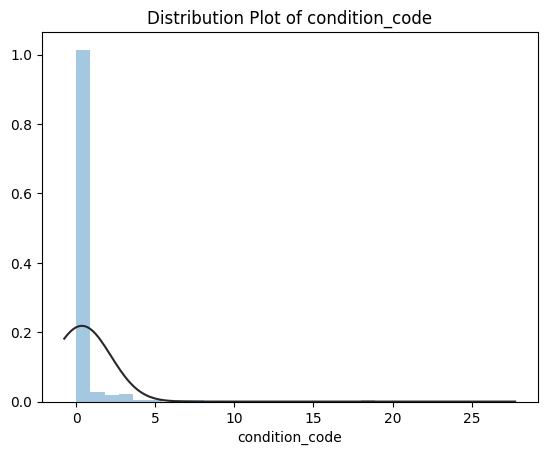

In [ ]:
# Create distribution plot
sns.distplot(dfaux['condition_code'], kde=False, fit=stats.norm, bins=30)
plt.title('Distribution Plot of condition_code')

# Show the plot
plt.show()

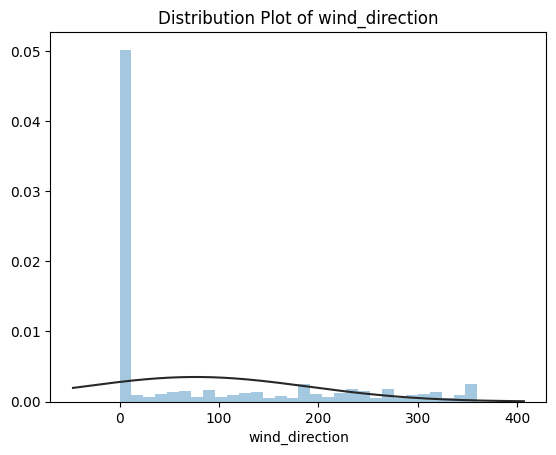

In [ ]:
# Create distribution plot
sns.distplot(dfaux['wind_direction'], kde=False, fit=stats.norm, bins=30)
plt.title('Distribution Plot of wind_direction')

# Show the plot
plt.show()

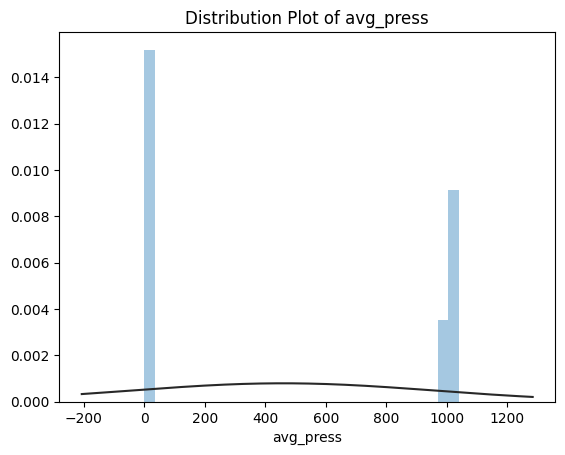

In [ ]:
# Create distribution plot
sns.distplot(dfaux['avg_press'], kde=False, fit=stats.norm, bins=30)
plt.title('Distribution Plot of avg_press')

# Show the plot
plt.show()

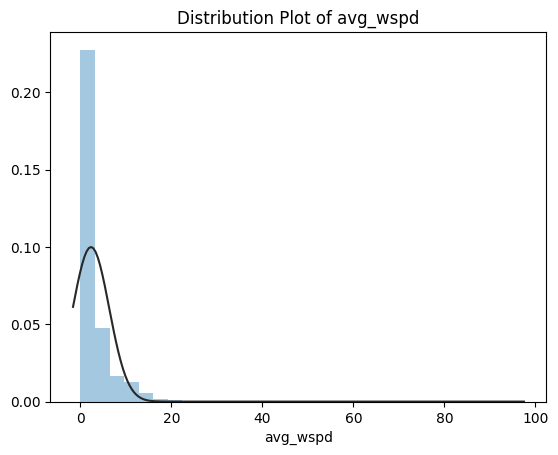

In [ ]:
# Create distribution plot
sns.distplot(dfaux['avg_wspd'], kde=False, fit=stats.norm, bins=30)
plt.title('Distribution Plot of avg_wspd')

# Show the plot
plt.show()

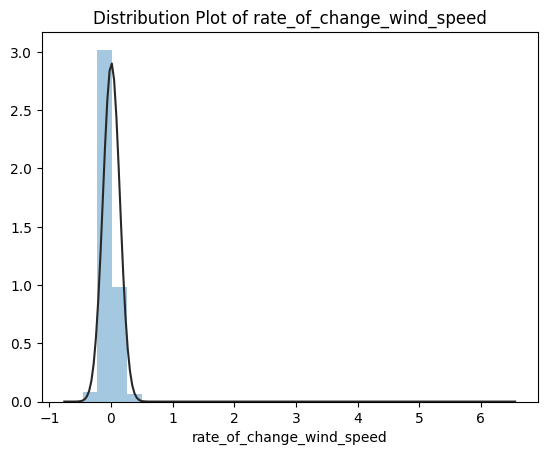

In [ ]:
# Create distribution plot
sns.distplot(dfaux['rate_of_change_wind_speed'], kde=False, fit=stats.norm, bins=30)
plt.title('Distribution Plot of rate_of_change_wind_speed')

# Show the plot
plt.show()

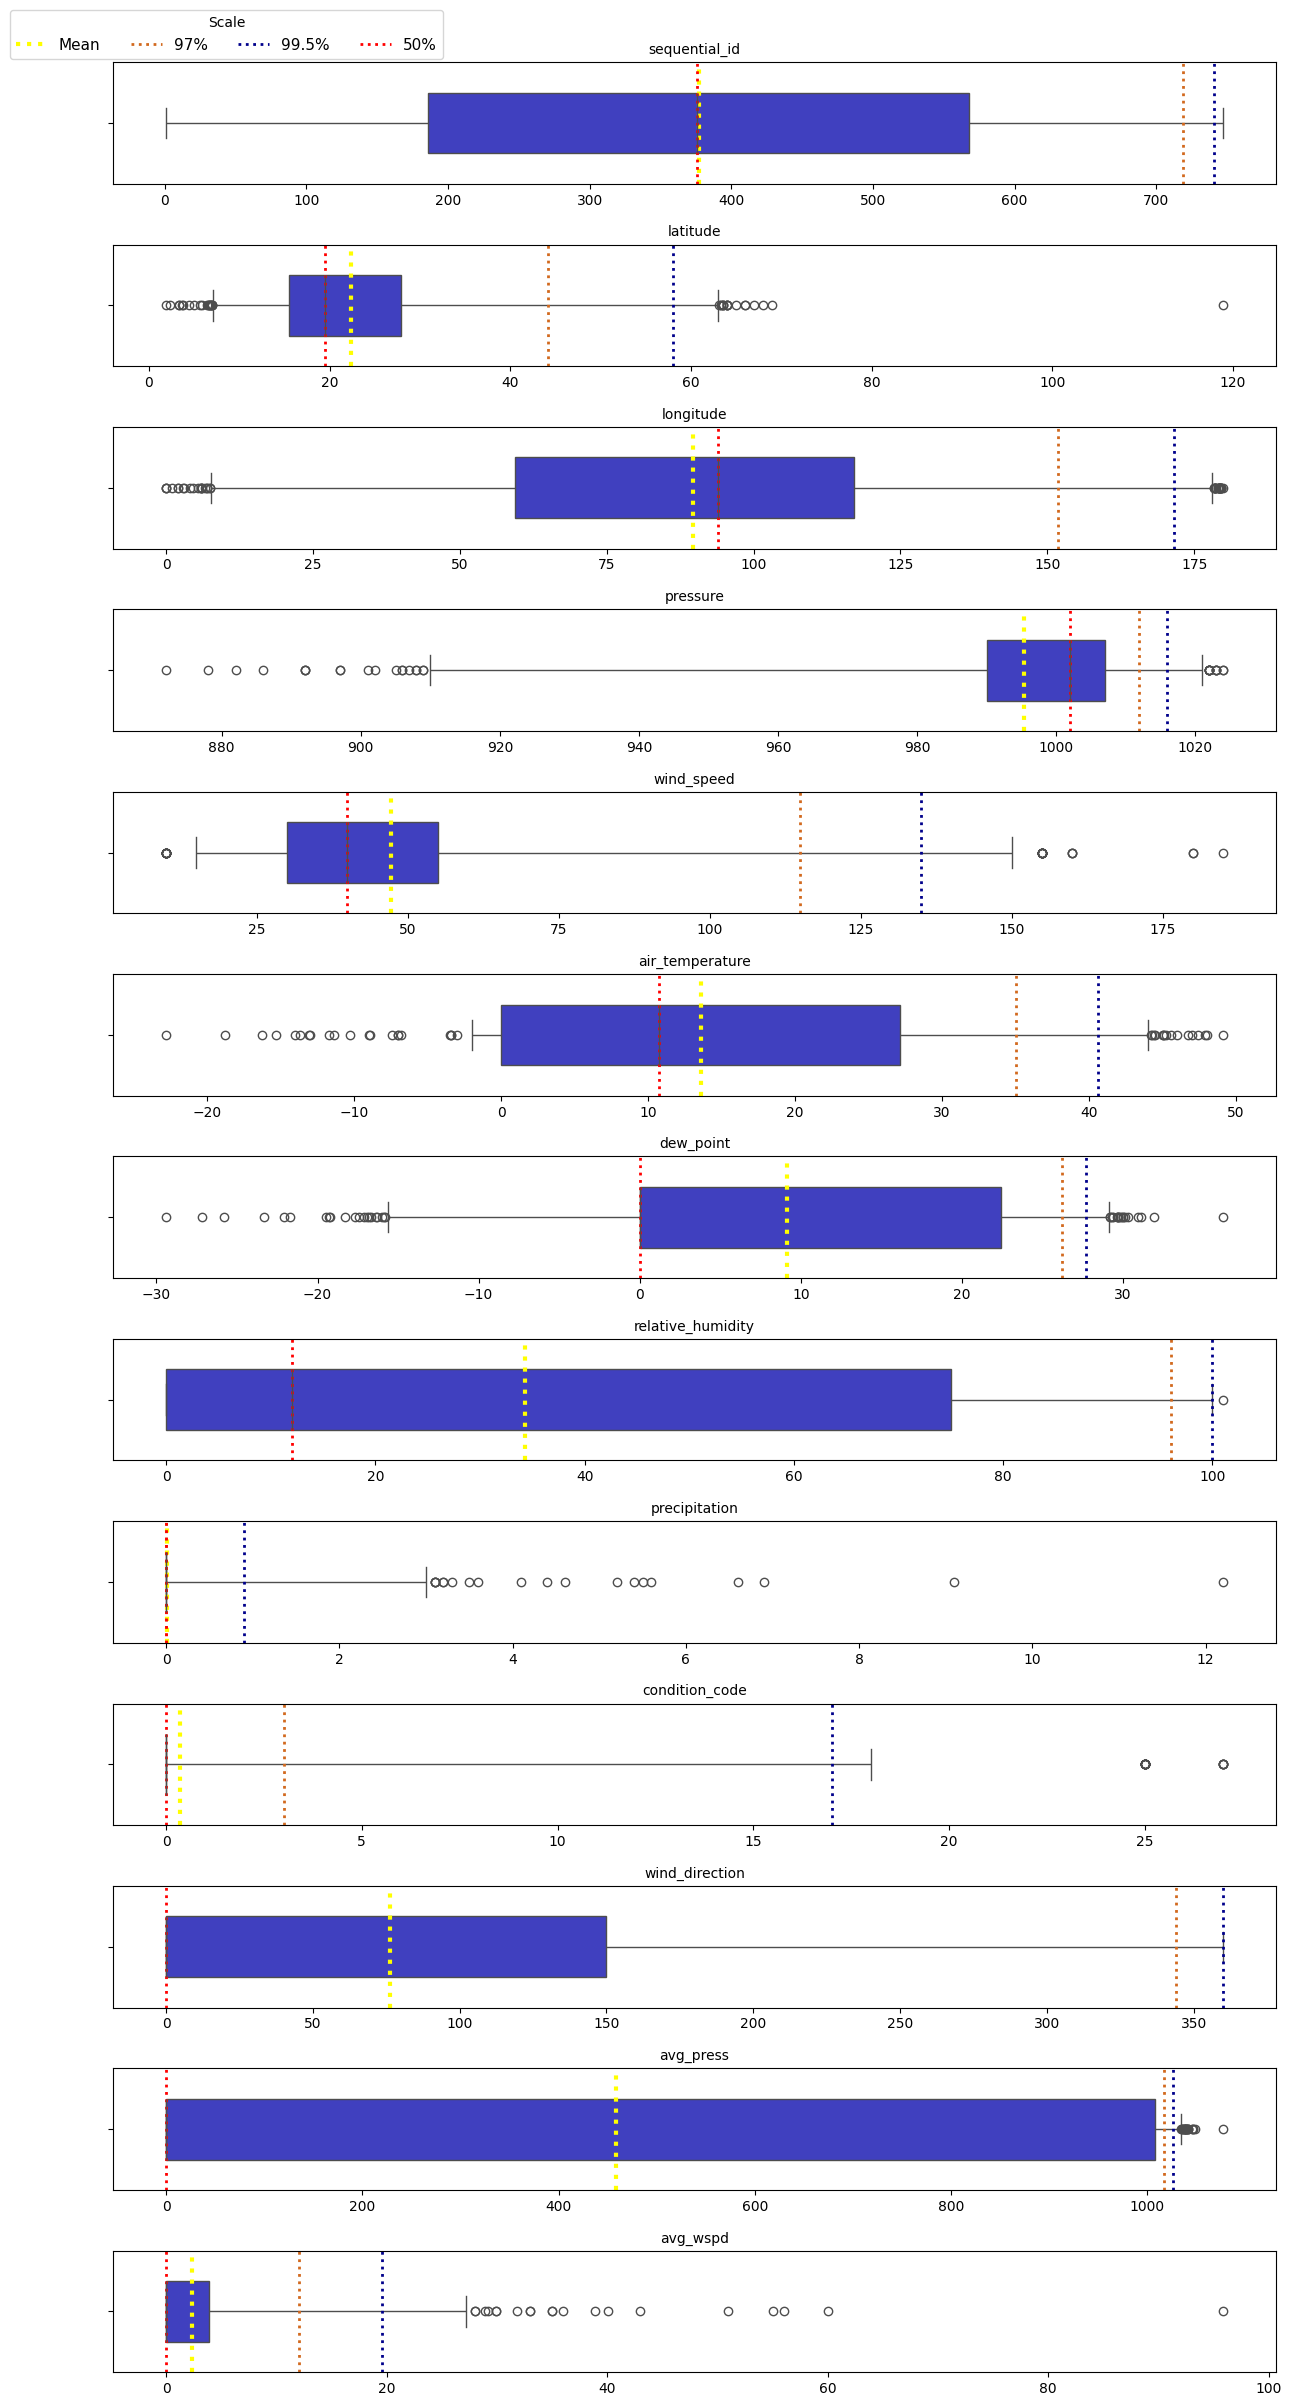

In [ ]:
# Create boxplots for numerical variables
fig = plt.figure(figsize=(15,30))
grid =  gridspec.GridSpec(13,1,figure=fig,hspace=.5,wspace=.05) # Modify number of plots
counter = 0
for i in range(13): # Number of features
    for j in range(1):
        if counter > 13:
            break

        subf = fig.add_subplot(grid[i, j]);
        sns.boxplot(x= dfaux.iloc[:, counter],orient='v',saturation=.5,color= 'blue', ax= subf,width=.5,whis=(.1,99.9));
        subf.axvline(dfaux.iloc[:, counter].mean(),color= 'yellow', label='Mean', linestyle=':',linewidth=3)
        subf.axvline(np.percentile(dfaux.iloc[:, counter].values,97),color= 'chocolate', label='97%', linestyle=':',linewidth=2)
        subf.axvline(np.percentile(dfaux.iloc[:, counter].values,99.5),color= 'darkblue', label='99.5%', linestyle=':',linewidth=2)
        subf.axvline(np.percentile(dfaux.iloc[:, counter].values,50),color= 'red', label='50%', linestyle=':',linewidth=2)
        subf.legend().set_visible(False)
        subf.set_xlabel('')
        subf.set_title('{}'.format(features[counter]),fontsize=10)
        counter += 1
        gc.collect()

# Adjust legend
handles, labels = subf.get_legend_handles_labels()
fig.legend(handles, labels,ncol=4, bbox_to_anchor=(0.35, 0.9),fontsize=11, title= 'Scale',title_fontsize=10,bbox_transform =fig.transFigure)

# Show the plot
plt.show();

#### Time Series Plotting

In [ ]:
df["datetime"] = pd.to_datetime(df["timestamp_utc"])

In [ ]:
df["datetime"].min(), df["datetime"].max()

(Timestamp('2002-05-24 18:00:00'), Timestamp('2023-11-27 12:00:00'))

In [ ]:
df["datetime"].max() - df["datetime"].min()

Timedelta('7856 days 18:00:00')

In [ ]:
# Create importan time series variables
df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df["day"] = df["datetime"].dt.day
df["hour"] = df["datetime"].dt.hour

In [ ]:
# Average of wind for each day of the week for each of the hurricane
df.groupby(
    [df["datetime"].dt.weekday, "name"])["wind_speed"].mean()

datetime  name                      
0         Genevieve                    30.000
          Hermine                      45.000
          Hilda                        85.000
          Hurricane Adrian             23.125
          Hurricane Agatha             90.000
                                        ...  
6         Tropical Storm Zeta          51.250
          Unnamed Subtropical Storm    45.000
          Unnamed Tropical Storm       30.000
          subtropical storm Nicole     40.000
          unnamed tropical storm       25.000
Name: wind_speed, Length: 2964, dtype: float64

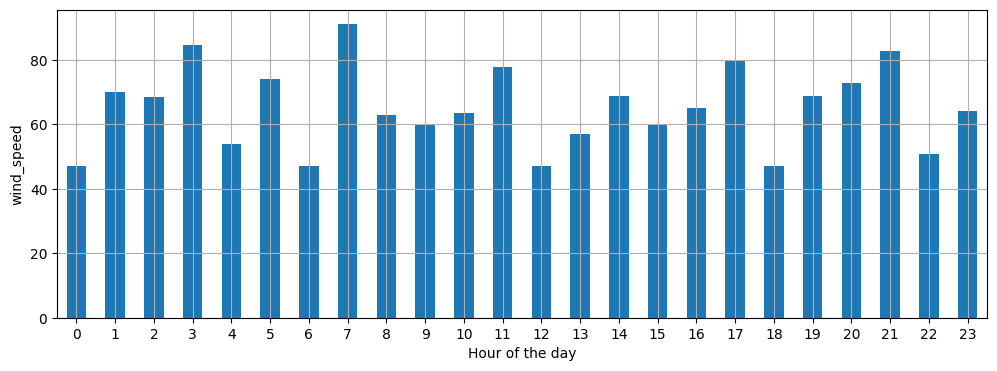

In [ ]:
# Typical wind pattern during the day of our time series. In other words, what is the average value for each hour of the day.
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby(df["datetime"].dt.hour)["wind_speed"].mean().plot(kind='bar', rot=0, ax=axs)

# Add title and labels
plt.xlabel("Hour of the day")
plt.ylabel("wind_speed")
plt.grid()

# Show the plot
plt.show()

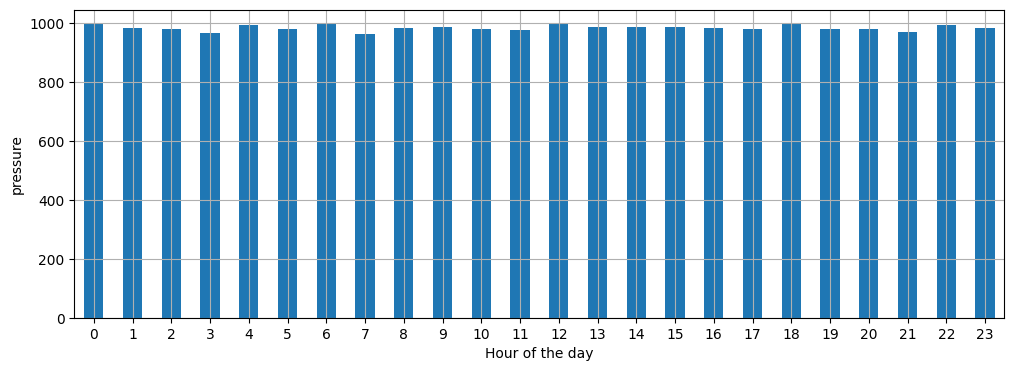

In [ ]:
# Typical pressure pattern during the day of our time series. In other words, what is the average value for each hour of the day.
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby(df["datetime"].dt.hour)["pressure"].mean().plot(kind='bar', rot=0, ax=axs)

# Add labels
plt.xlabel("Hour of the day");
plt.ylabel("pressure")
plt.grid()

# Show the plot
plt.show()

In [ ]:
#Create pivot tables for each continuos variables
df_ts_wind = pd.pivot_table(df,values='wind_speed',index='datetime',columns='name')
df_ts_press = pd.pivot_table(df,values='pressure',index='datetime',columns='name')

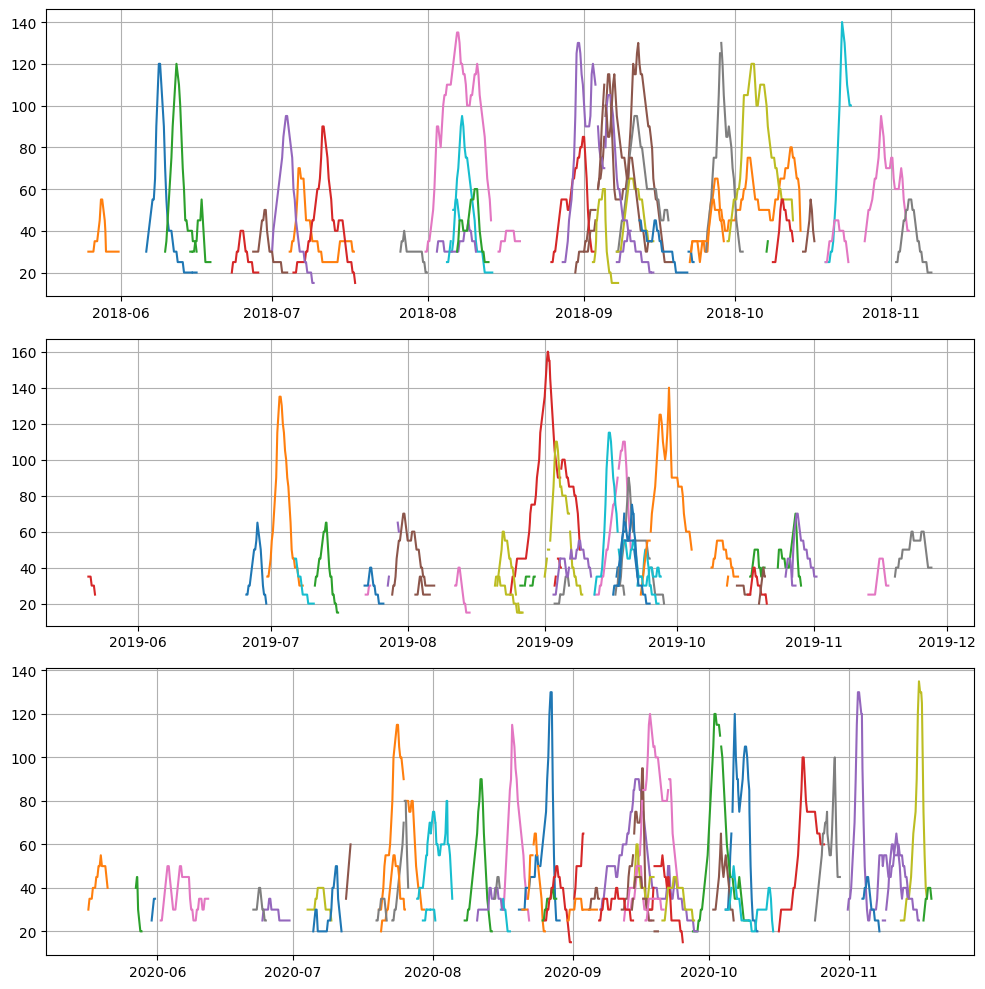

In [ ]:
# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(10, 10))

# Plot some data on each subplot
ax1.plot(df_ts_wind["2018-01-01":"2018-12-31"].dropna(axis=1, how='all'))
ax2.plot(df_ts_wind["2019-01-01":"2019-12-31"].dropna(axis=1, how='all'))
ax3.plot(df_ts_wind["2020-01-01":"2020-12-31"].dropna(axis=1, how='all'))

# Adjust the spacing between subplots
plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9, hspace=0.4)

# Show the plot
plt.tight_layout()
ax1.grid()
ax2.grid()
ax3.grid()
plt.show()

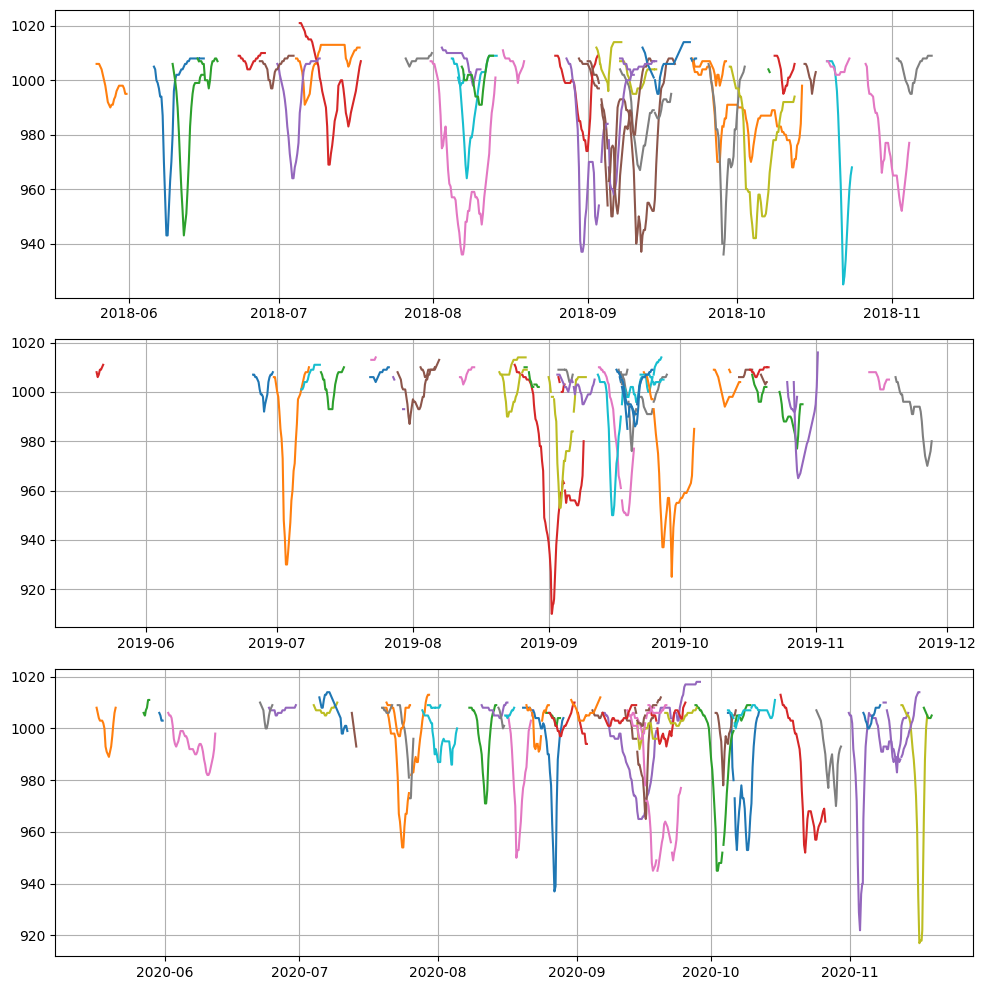

In [ ]:
# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(10, 10))

# Plot some data on each subplot
ax1.plot(df_ts_press["2018-01-01":"2018-12-31"].dropna(axis=1, how='all'))
ax2.plot(df_ts_press["2019-01-01":"2019-12-31"].dropna(axis=1, how='all'))
ax3.plot(df_ts_press["2020-01-01":"2020-12-31"].dropna(axis=1, how='all'))

# Adjust the spacing between subplots
plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9, hspace=0.4)

# Show the plot
plt.tight_layout()
ax1.grid()
ax2.grid()
ax3.grid()
plt.show()

## Correlation Analysis

In [ ]:
corr = dfaux.corr(method='pearson')
corr_positive = corr.unstack().sort_values(ascending=False).drop_duplicates()
corr_positive = corr_positive[1:6]
corr_negative = corr.unstack().sort_values(ascending=True).drop_duplicates()
corr_negative = corr_negative[:5]
print("Top 5 positive correlations:")
print(corr_positive)
print("\nTop 5 negative correlations:")
print(corr_negative)

Top 5 positive correlations:
dew_point          relative_humidity   0.912
avg_press          air_temperature     0.840
dew_point          air_temperature     0.826
relative_humidity  avg_press           0.798
air_temperature    relative_humidity   0.765
dtype: float64

Top 5 negative correlations:
pressure   wind_speed        -0.942
latitude   longitude         -0.444
longitude  avg_wspd          -0.253
           air_temperature   -0.233
           avg_press         -0.229
dtype: float64


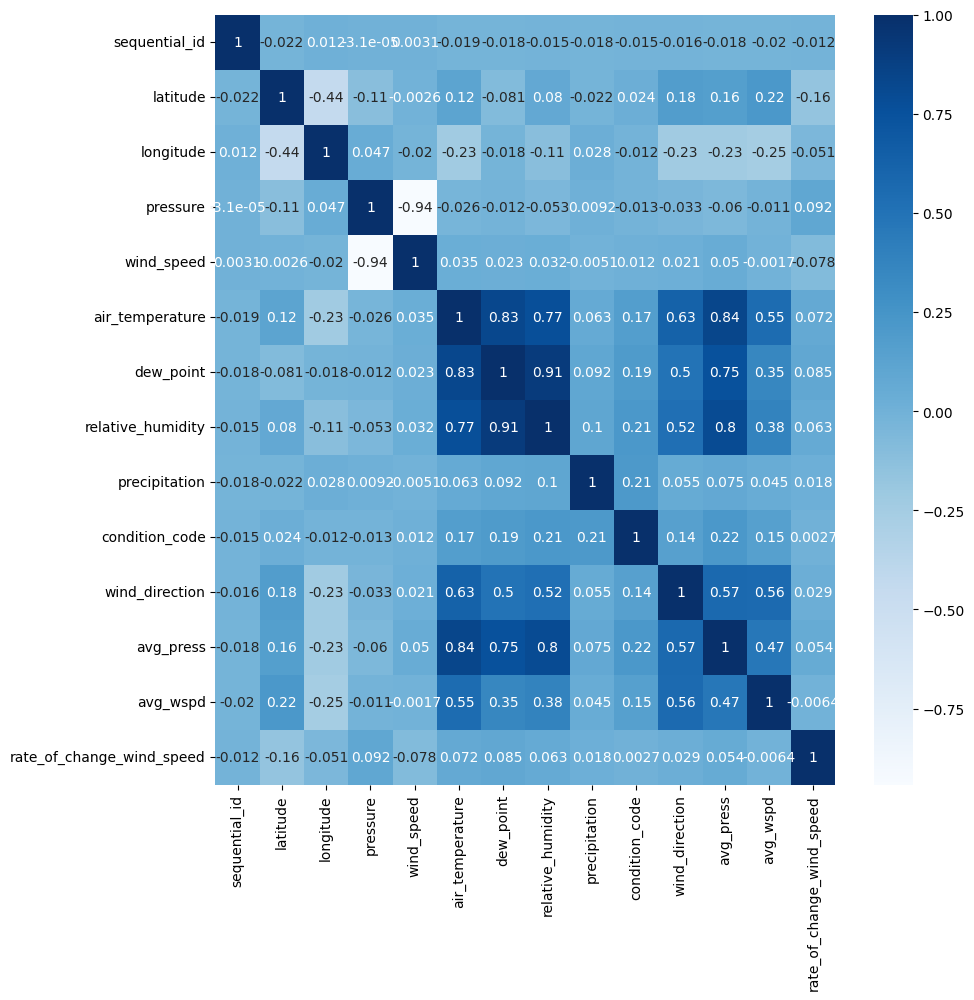

In [ ]:
# Pearson Correlation
plt.figure(figsize=(10,10))
cor = dfaux.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)

# Show the plot
plt.show()

In [ ]:
corr = dfaux.corr(method='spearman')
corr_positive = corr.unstack().sort_values(ascending=False).drop_duplicates()
corr_positive = corr_positive[1:6]
corr_negative = corr.unstack().sort_values(ascending=True).drop_duplicates()
corr_negative = corr_negative[:5]
print("Top 5 positive correlations:")
print(corr_positive)
print("\nTop 5 negative correlations:")
print(corr_negative)

Top 5 positive correlations:
avg_wspd         wind_direction      0.888
dew_point        relative_humidity   0.883
air_temperature  dew_point           0.809
avg_press        relative_humidity   0.790
air_temperature  relative_humidity   0.779
dtype: float64

Top 5 negative correlations:
wind_speed       pressure    -0.908
longitude        latitude    -0.365
                 avg_wspd    -0.282
wind_direction   longitude   -0.260
air_temperature  longitude   -0.248
dtype: float64


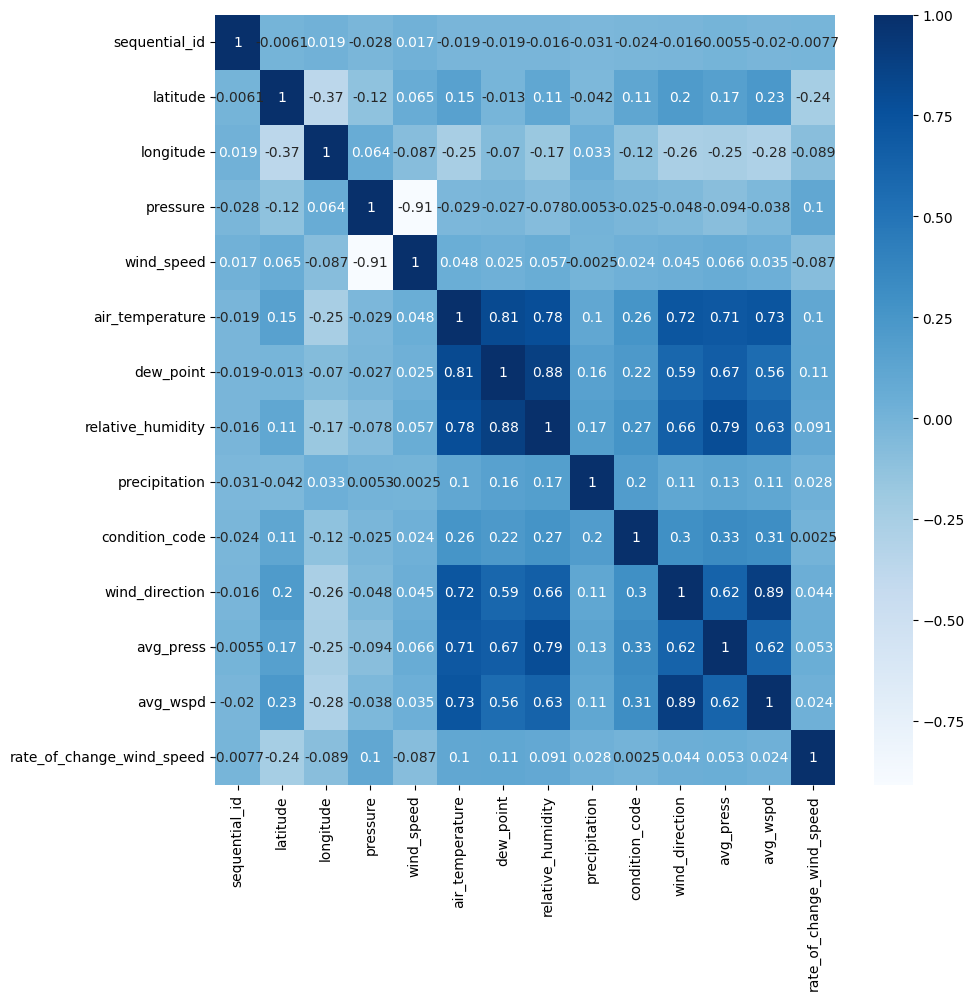

In [ ]:
# Spearman Correlation
plt.figure(figsize=(10,10))
cor = dfaux.corr(method='spearman')
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)

# Show the plot
plt.show()

In [ ]:
# Top 10 of predict power matrix in dfaux and filter values of predict_itself in column case
matrix = pps.matrix(dfaux)
matrix.sort_values(by=['ppscore'], ascending=False)[matrix.case  != 'predict_itself'].head(10)

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
103,relative_humidity,air_temperature,0.809,regression,True,mean absolute error,13.465,2.567,DecisionTreeRegressor()
89,dew_point,air_temperature,0.798,regression,True,mean absolute error,13.465,2.714,DecisionTreeRegressor()
91,dew_point,relative_humidity,0.774,regression,True,mean absolute error,34.529,7.807,DecisionTreeRegressor()
104,relative_humidity,dew_point,0.762,regression,True,mean absolute error,9.663,2.296,DecisionTreeRegressor()
81,air_temperature,avg_press,0.762,regression,True,mean absolute error,467.568,111.357,DecisionTreeRegressor()
2,sequential_id,longitude,0.752,regression,True,mean absolute error,30.634,7.602,DecisionTreeRegressor()
95,dew_point,avg_press,0.752,regression,True,mean absolute error,467.568,116.112,DecisionTreeRegressor()
109,relative_humidity,avg_press,0.742,regression,True,mean absolute error,467.568,120.721,DecisionTreeRegressor()
77,air_temperature,relative_humidity,0.725,regression,True,mean absolute error,34.529,9.495,DecisionTreeRegressor()
59,wind_speed,pressure,0.702,regression,True,mean absolute error,11.743,3.499,DecisionTreeRegressor()


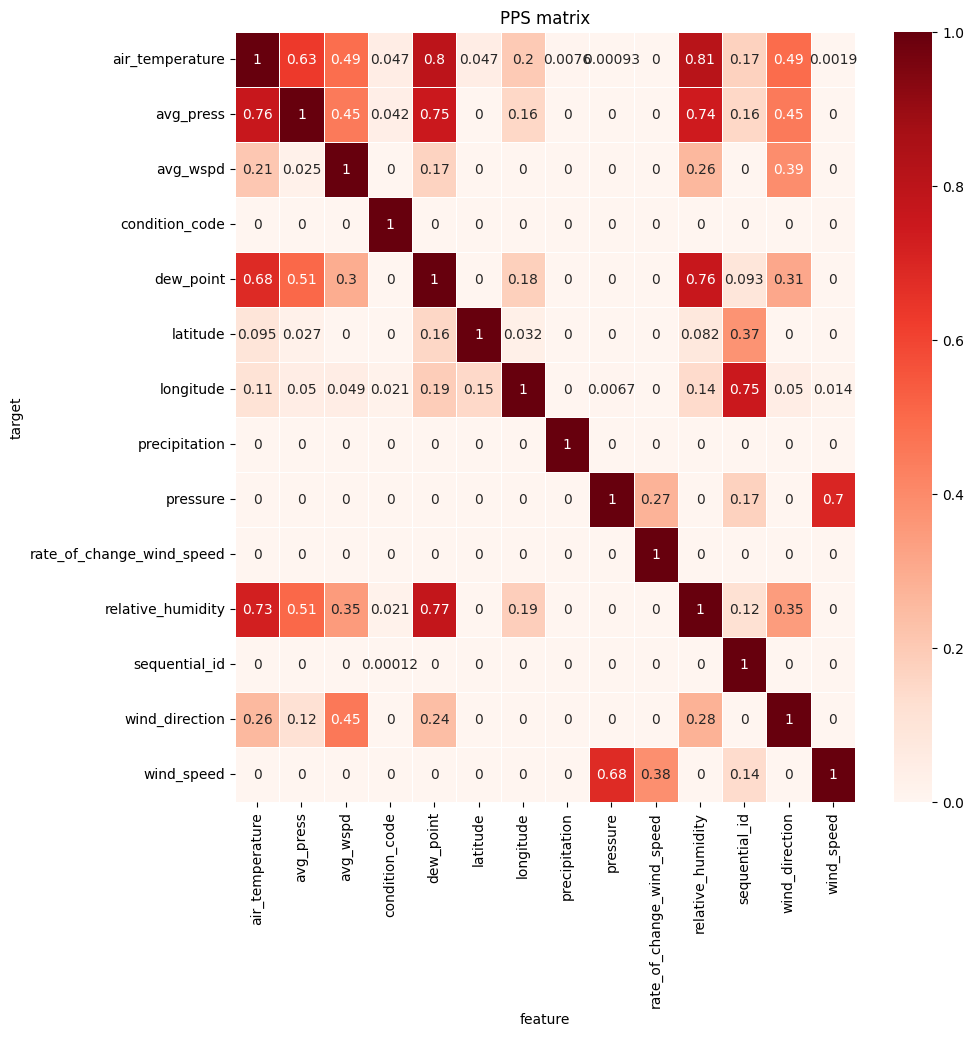

In [ ]:
# Built Predictive Power Matrix
matrix = pps.matrix(dfaux)
heatmap(matrix)

# Show the plot
plt.show()